In [1]:
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from pycbc import psd
from simple_pe.waveforms import parameter_bounds, check_physical, two_ecc_harms_SNR
from simple_pe.param_est import find_metric_and_eigendirections, SimplePESamples, pe

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
with open(os.path.join('data', '4d_samples_pe_result'), 'rb') as fp:
    pe_result = pickle.load(fp)
metric = pe_result.metric

In [7]:
def const_mm_point(metric, mm, target_par, base_vals, direction=1,
                   fix_dirs=[]):
    """
    Find most extreme point of an n-d ellipsoid corresponding to a
    given metric.

    :param metric: metric
    :type metric: metric object, required
    :param mm: mismatch
    :type mm: float, required
    :param target_par: parameter to find extreme of
    :type target_par: string, required
    :param base_vals: base parameter values of metric
    :type base_vals: dictionary, required
    :param direction: whether to find maximum (+1) or minimum (-1)
    :type direction: integer, optional
    :param fix_dirs: parameters to keep fixed
    :type fix_dirs: list of strings, optional

    :return extreme_point: parameter values at extreme point
    :rtype extreme_point: dictionary
    """

    # Get metric
    keys = list(metric.dxs.keys())
    temp_metric = metric.metric.copy()
    for fd in fix_dirs:
        ind = keys.index(fd)
        temp_metric = np.delete(temp_metric, (ind), axis=0)
        temp_metric = np.delete(temp_metric, (ind), axis=1)
        keys.remove(fd)

    # Find A
    t_ind = keys.index(target_par)
    A = temp_metric[t_ind][t_ind]

    # Find B
    param_keys = [key for key in keys if key != target_par]
    B = [temp_metric[t_ind][k] for k in range(len(keys)) if k != t_ind]
    B = np.array(B)

    # Find inverse of C
    C = np.delete(temp_metric, (t_ind), axis=0)
    C = np.delete(C, (t_ind), axis=1)
    C_inv = np.linalg.inv(C)

    # Find change in target parameter to reach mismatch
    BC_term = -np.matmul(B, np.matmul(C_inv, B))
    d_target = direction*np.sqrt(mm/(A+BC_term))

    # Find extreme point at specified mismatch
    dxs = -1*np.matmul(C_inv, B) * d_target
    extreme_point = {target_par: base_vals[target_par]+d_target}
    for i, key in enumerate(param_keys):
        extreme_point[key] = dxs[i] + base_vals[key]

    return extreme_point


In [35]:
def degeneracy_line(metric, e10s, mins=None, maxs=None,
                    dirs=['ecc10sqrd', 'chirp_mass',
                          'symmetric_mass_ratio', 'chi_eff']):
    """
    Calculate points on a metric's degeneracy line corresponding to given
    eccentricities.

    :param metric: metric
    :type metric: metric object, required
    :param e10s: eccentricities
    :type e10s: float or array of floats, required
    :param mins: minimum parameter bounds
    :type mins: dictionary, optional
    :param maxs: maximum parameter bounds
    :type maxs: dictionary, optional
    :param dirs: parameters to calculate degeneracy line
    :type dirs: list, otpional

    :return new_samples: degeneracy line parameter values
    :rtype new_samples: SimplePESamples object
    """

    # Setup
    if mins is None:
        mins = parameter_bounds.param_mins
    if maxs is None:
        maxs = parameter_bounds.param_maxs
    base_vals = {direct: metric.x[direct][0] for direct in dirs}
    e10s = np.array([e10s]).flatten()
    rail_dirs = dirs.copy()
    rail_dirs.remove('ecc10sqrd')
    railing = []
    for i in range(len(e10s)):
        railing.append('0'*(len(dirs)-1))

    # Loop over iterations
    finished = np.zeros_like(e10s)
    degen_points = {}
    new_vals = [base_vals for i in range(len(e10s))]
    while np.sum(finished) < len(finished):

        # Calculate degenerate directions for all necessary projections
        for degen_key in set(railing):
            if degen_key not in degen_points.keys():
                fix_dirs = [rail_dirs[i] for i in range(len(rail_dirs))
                            if int(degen_key[i])]
                degen_points[degen_key] = const_mm_point(
                    metric, metric.mismatch, 'ecc10sqrd', base_vals,
                    fix_dirs=fix_dirs
                    )
                for direct in fix_dirs:
                    degen_points[degen_key][direct] = base_vals[direct]

        # For each eccentricity value
        for i, e10 in enumerate(e10s):
            if finished[i]:
                continue
            # print(f'calculating {e10}, railing in {railing[i]}')

            # Calculate new value
            rail_pt = degen_points[railing[i]]
            dist_denom = (rail_pt['ecc10sqrd'] - base_vals['ecc10sqrd'])
            dist = (e10**2 - new_vals[i]['ecc10sqrd'])/dist_denom
            dx = {}
            for direct in dirs:
                dx[direct] = dist*(rail_pt[direct] - base_vals[direct])
            new_vals_pos, dx_pos = new_vals[i].copy(), dx.copy()
            for key in list(dx_pos.keys()):
                if dx_pos[key] == 0:
                    new_vals_pos.pop(key)
                    dx_pos.pop(key)
            alpha = check_physical(new_vals_pos, dx_pos, 1,
                                   maxs=maxs, mins=mins)
            dist *= alpha
            new_point = new_vals[i].copy()
            for direct in dirs:
                new_point[direct] += dist*(rail_pt[direct] - base_vals[direct])
            # print(new_vals[i], new_point)
            new_vals[i] = new_point

            # Check if railing
            if alpha < 1:
                rail = ''
                for raildir in rail_dirs:
                    max_rail = np.isclose(new_point[raildir], maxs[raildir],
                                          atol=1e-15)
                    min_rail = np.isclose(new_point[raildir], mins[raildir],
                                          atol=1e-15)
                    # print(e10, new_point[raildir], maxs[raildir], max_rail)
                    # print(e10, new_point[raildir], mins[raildir], min_rail)
                    # print('\n')
                    if max_rail or min_rail:
                        rail += '1'
                    else:
                        rail += '0'
                railing[i] = rail
            else:
                finished[i] = True

    # Return as SimplePESamples object
    new_samples = {d: [nv[d] for nv in new_vals] for d in dirs}
    new_samples = SimplePESamples(new_samples)

    return new_samples

In [41]:
mins = parameter_bounds.param_mins.copy()
maxs = parameter_bounds.param_maxs.copy()
mins['symmetric_mass_ratio'] = 0.2
degeneracy_line(metric, np.linspace(0, 0.5, 6), mins=mins, maxs=maxs)

{'ecc10sqrd': Array([0.  , 0.01, 0.04, 0.09, 0.16, 0.25]),
 'chirp_mass': Array([24.70401678, 24.57248468, 24.1778884 , 23.53516731,
        22.65428624, 21.52172486]),
 'symmetric_mass_ratio': Array([0.20611047, 0.20515202, 0.20227666, 0.2       ,
        0.2       , 0.2       ]),
 'chi_eff': Array([ 0.1399452 ,  0.13353027,  0.11428548,  0.07533356,
         0.01208724, -0.06922947])}

In [40]:
degeneracy_line(metric, np.linspace(0, 0.5, 6))

{'ecc10sqrd': Array([0.  , 0.01, 0.04, 0.09, 0.16, 0.25]),
 'chirp_mass': Array([24.70401678, 24.57248468, 24.1778884 , 23.52022792,
        22.59950326, 21.4157144 ]),
 'symmetric_mass_ratio': Array([0.20611047, 0.20515202, 0.20227666, 0.19748439,
        0.19077522, 0.18214914]),
 'chi_eff': Array([ 0.1399452 ,  0.13353027,  0.11428548,  0.08221084,
         0.03730634, -0.02042801])}

# Test 3d metric

In [42]:
def generate_ellipsoid(metric, base_vals, npts=1000, scale=1):

    # Points on an n-dimensional sphere
    n = len(metric.evec)
    points = np.random.rand(n, npts)*2-1
    points /= np.linalg.norm(points, axis=0)

    # Transform to n-dimensional ellipsoid
    ellipse = np.matmul(metric.normalized_evecs().samples, scale*points)
    keys = list(metric.dxs.keys())

    # Recentre to base parameter values
    ellipse_dict = {}
    for i, key in enumerate(keys):
        ellipse_dict[key] = ellipse[i] + base_vals[key]

    return ellipse_dict

In [43]:
# Defines PSD settings
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': 20,
        'f_high': 8192,
        'length': 32
        }
snr = 18
psds['delta_f'] = 1. / psds['length']
approximant = 'TEOBResumS-Dali'

# Calculates PSD
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])
pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

# Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc10sqrd': 0, 'chi_eff': 0}
par_dirs = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio']

start = time.time()
metric_3d = find_metric_and_eigendirections(pars, par_dirs, snr=snr, approximant=approximant, f_low=psds['f_low'], psd=pycbc_psd['harm'])
end = time.time()
print(f'{end-start:.2f} seconds')

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 0 < 20| error 0.0095 > 0.00048

Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 1 < 20| error 0.0018 > 0.00048: 

Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 2 < 20| error 0.00046 > 0.00048: 

59.47 seconds


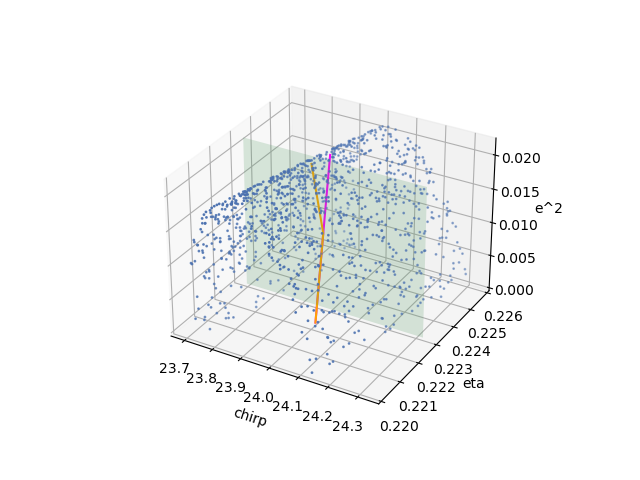

In [47]:
# Setup 3d plot
plt.close()
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
base_pars = {'ecc10sqrd': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9}
ellipse_3d = generate_ellipsoid(metric_3d, base_pars, npts=25000, scale=1)
extreme_point = const_mm_point(metric_3d, metric_3d.mismatch, 'ecc10sqrd', base_pars)

# Cut unphysical parts of 3d ellipsoid or parts outside of plot
keep_inds = np.where(np.logical_and(np.logical_and(ellipse_3d['ecc10sqrd']>=0, ellipse_3d['symmetric_mass_ratio']<=0.226),
                                    ellipse_3d['symmetric_mass_ratio']>=0.22))[0]
for key in ellipse_3d.keys():
    ellipse_3d[key] = ellipse_3d[key][keep_inds]

# Plot 3d ellipsoid and degeneracy line
ax.scatter(ellipse_3d['chirp_mass'], ellipse_3d['symmetric_mass_ratio'], ellipse_3d['ecc10sqrd'], s=1, c='b')
chirp_line = np.linspace(base_pars['chirp_mass'], extreme_point['chirp_mass'], 101)
eta_line = np.linspace(base_pars['symmetric_mass_ratio'], extreme_point['symmetric_mass_ratio'], 101)
e2_line = np.linspace(base_pars['ecc10sqrd'], extreme_point['ecc10sqrd'], 101)
ax.plot(chirp_line, eta_line, e2_line, c='magenta')

# Plot plane and degeneracy line with plane as bound
xx, yy = np.meshgrid(ax.get_xlim(), [0.223, 0.223])
z = np.array([[0, 0], [0.022, 0.022]])
ax.plot_surface(xx, yy, z, color='g', alpha=0.2)
mins = parameter_bounds.param_mins.copy()
maxs = parameter_bounds.param_maxs.copy()
maxs['symmetric_mass_ratio'] = 0.223
degen_points = degeneracy_line(metric_3d, e2_line**0.5, dirs=['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio'], mins=mins, maxs=maxs)
ax.plot(degen_points['chirp_mass'], degen_points['symmetric_mass_ratio'], e2_line, c='orange')

# Plot formatting
ax.set_xlabel('chirp')
ax.set_ylabel('eta')
ax.set_zlabel('e^2')
ax.set_zlim(0,0.022)
ylim = ax.get_ylim()
ax.set_ylim(0.22, 0.226)
plt.show()

# Investigating zero-ecc run

In [2]:
with open(os.path.join('pe_4d_pipeline', 'dataslot_9', 'samples_info'), 'rb') as fp:
    samples_info = pickle.load(fp)
with open(os.path.join('pe_4d_pipeline', 'dataslot_9', 'peak_info'), 'rb') as fp:
    peak_info = pickle.load(fp)

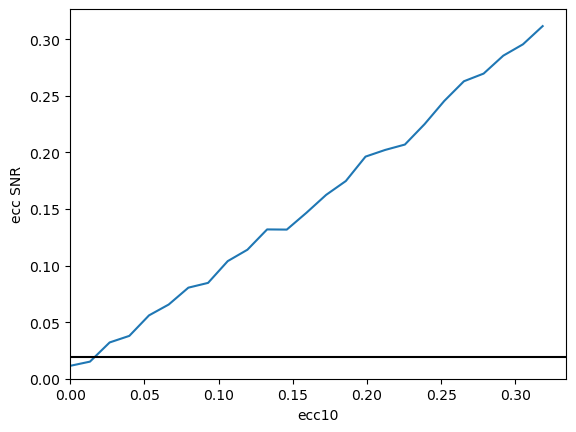

In [3]:
peak_ecc_SNR, peak_ecc_MA = two_ecc_harms_SNR({k: np.abs(peak_info['peak_SNRs'][k]) for k in [0,1,-1]},
                                              {k: np.angle(peak_info['peak_SNRs'][k]) for k in [0,1,-1]})

plt.plot(samples_info['ecc_SNR_grid'][1]['ecc10sqrd']**0.5, np.abs(samples_info['ecc_SNR_grid'][0]))
plt.axhline(peak_ecc_SNR, c='k')
plt.xlabel('ecc10')
plt.ylabel('ecc SNR')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [4]:
def interpolate_ecc_SNR_samples(metric_prior_samples, ecc_SNR_grid, SNRs, two_ecc_harms=True):
    """
    Interpolates grid of eccentric SNRs to samples and performs rejection sampling.

    Parameters:
        pe_result: Result object
        ecc_SNR_grid: Interpolant grid.
        SNRs: SNRs in each harmonic at eccentric peak point.
        two_ecc_harms: Whether to include two higher eccentric harmonics.

    Returns:
        samples_ecc_cut: Samples after rejection sampling.
    """

    # Interpolate samples to ecc SNR from 5x5x5x5 grid
    interp_pts = np.sqrt(ecc_SNR_grid[1]['ecc10sqrd'].copy())
    samples = metric_prior_samples
    samples.generate_ecc()
    interp_e_SNR = interp1d(interp_pts, ecc_SNR_grid[0])
    ecc_SNR_samples = interp_e_SNR(np.sqrt(samples['ecc10sqrd']))

    if two_ecc_harms:
        # Compute kde on peak SNR with two higher harmonics
        n = 10**5
        s_1 = np.random.normal(np.real(SNRs[1]), 1, n) + 1j*np.random.normal(np.imag(SNRs[1]), 1, n)
        s_n1 = np.random.normal(np.real(SNRs[-1]), 1, n) + 1j*np.random.normal(np.imag(SNRs[-1]), 1, n)
        s_1n1_abs, s_1n1_phase = two_ecc_harms_SNR({0: np.full(n, np.abs(SNRs[0])), 1: np.abs(s_1), -1: np.abs(s_n1)},
                                                   {0: np.full(n, np.angle(SNRs[0])), 1: np.angle(s_1), -1: np.angle(s_n1)})
        s_1n1 = s_1n1_abs*np.exp(1j*s_1n1_phase)
        kde_samples = np.array([np.real(s_1n1), np.imag(s_1n1)])
        kernel = gaussian_kde(kde_samples)
        ecc_SNR_weights = kernel([np.real(ecc_SNR_samples), np.imag(ecc_SNR_samples)])
    else:
        # Calculate weights with one higher harmonic using pdf
        real_arg = -0.5*(np.abs(SNRs[0])*(np.real(ecc_SNR_samples)-np.real(SNRs[1]/SNRs[0])))**2
        imag_arg = -0.5*(np.abs(SNRs[0])*(np.imag(ecc_SNR_samples)-np.imag(SNRs[1]/SNRs[0])))**2
        ecc_SNR_weights = np.exp(real_arg)*np.exp(imag_arg)

    # Perform rejection sampling
    ecc_SNR_weights_norm = ecc_SNR_weights/np.max(ecc_SNR_weights)
    samples_ecc_cut = samples[ecc_SNR_weights_norm>=np.random.rand(len(ecc_SNR_weights))]

    return samples_ecc_cut, ecc_SNR_samples, ecc_SNR_weights_norm

In [5]:
ecc_samples = interpolate_ecc_SNR_samples(samples_info['metric_prior_samples'], samples_info['ecc_SNR_grid'], peak_info['peak_SNRs'])

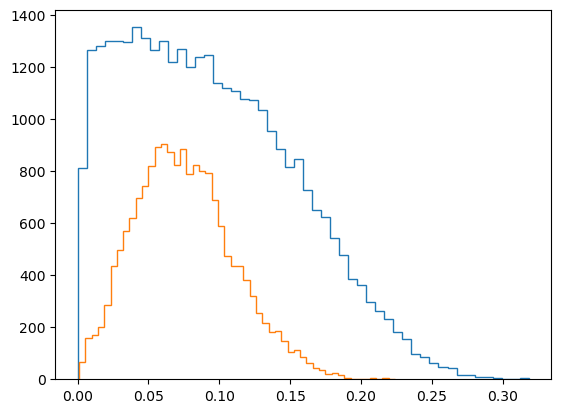

In [6]:
_ = plt.hist(samples_info['metric_prior_samples']['ecc10'], bins=50, histtype='step', density=False)
_ = plt.hist(ecc_samples[0]['ecc10'], bins=50, histtype='step', density=False)
plt.show()

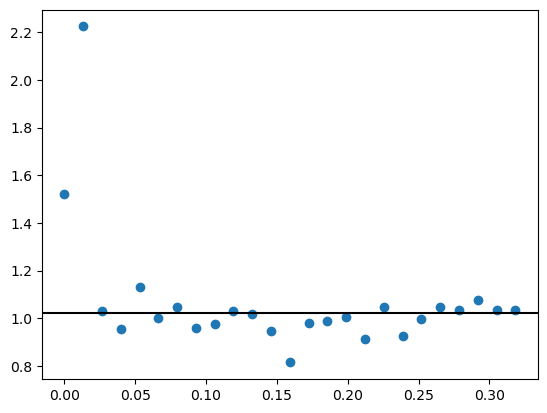

In [7]:
plt.axhline(peak_ecc_MA, c='k')
plt.scatter(samples_info['ecc_SNR_grid'][1]['ecc10sqrd']**0.5, np.angle(samples_info['ecc_SNR_grid'][0]))
plt.show()

# Peak at zero SNR

In [103]:
# Generate samples
n = 10**5
# s_1 = np.random.normal(np.real(peak_info['peak_SNRs'][1]), 1, n) + 1j*np.random.normal(np.imag(peak_info['peak_SNRs'][1]), 1, n)
# s_n1 = np.random.normal(np.real(peak_info['peak_SNRs'][-1]), 1, n) + 1j*np.random.normal(np.imag(peak_info['peak_SNRs'][-1]), 1, n)
s_1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_n1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_1n1_abs, s_1n1_phase = two_ecc_harms_SNR({0: np.full(n, np.abs(peak_info['peak_SNRs'][0])), 1: np.abs(s_1), -1: np.abs(s_n1)},
                                           {0: np.full(n, np.angle(peak_info['peak_SNRs'][0])), 1: np.angle(s_1), -1: np.angle(s_n1)})
s_1n1 = s_1n1_abs*np.exp(1j*s_1n1_phase)
kde_samples = np.array([np.real(s_1n1), np.imag(s_1n1)])
kernel = gaussian_kde(kde_samples)

In [104]:
# Calculate kde and contour levels
kde_x, kde_y = np.mgrid[np.min(np.real(s_1n1)):np.max(np.real(s_1n1)):51j, np.min(np.imag(s_1n1)):np.max(np.imag(s_1n1)):51j]
kde_z = kernel(np.array([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)
kde_z /= np.max(kde_z)

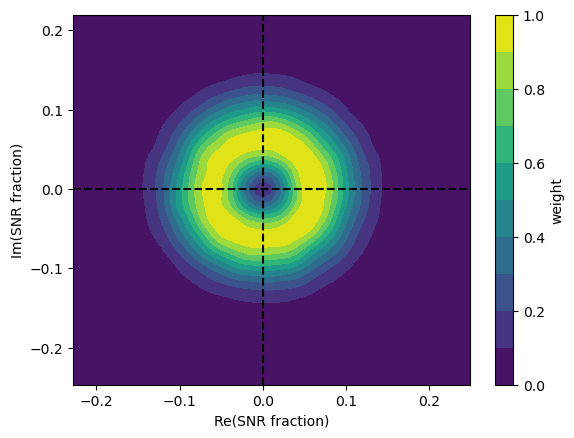

In [105]:
# Make plot
plt.axvline(0, c='k', ls='dashed', zorder=5)
plt.axhline(0, c='k', ls='dashed', zorder=5)
plt.contourf(kde_x, kde_y, kde_z, cmap='viridis', vmin=0, vmax=1, levels=np.linspace(0, 1, 11))
plt.colorbar(label='weight')
plt.xlabel('Re(SNR fraction)')
plt.ylabel('Im(SNR fraction)')
plt.show()

# Using third dof

In [121]:
def two_ecc_harms_SNR_test(rhos, phis):

    """
    Calculate fraction of SNR in first two higher harmonics in
    phase consistent way.

    Parameters:
        rhos: Magnitudes of SNR with each harmonic.
        phis: Phases of matches with each harmonic.

    Returns:
        SNRs: Fractional eccentric SNR.
        MAs: Combined measurement of phase.
    """

    # Require 0,1,-1 harmonics
    assert set([0, 1, -1]).issubset(set(rhos.keys()))

    # Check if inputs are arrays
    array = False
    if len(np.shape(rhos[0])) > 0:
        array = True
    else:
        rhos = {k: np.array([v]) for k, v in rhos.items()}
        phis = {k: np.array([v]) for k, v in phis.items()}

    # Check if inconsistent by more than pi/2 radians
    angle_arg = 2*phis[0]-phis[1]-phis[-1]
    condition = np.where(np.abs((angle_arg+np.pi) % (2*np.pi) - np.pi)
                         <= np.pi/2)
    mask = np.zeros_like(rhos[0], bool)
    mask[condition] = True

    # Calculate SNR in higher harmonics
    log_Ls = np.ones_like(rhos[0], float)
    MAs = np.ones_like(rhos[0], float)

    # SNR, log_L
    cross_term_sqrd = rhos[1][mask]**4 + \
        2*rhos[1][mask]**2*rhos[-1][mask]**2*np.cos(2*angle_arg[mask]) + \
        rhos[-1][mask]**4
    log_L = (1/4)*(rhos[1][mask]**2+rhos[-1][mask]**2+np.sqrt(cross_term_sqrd))
    log_Ls[mask] = log_L
    log_L = (1/2)*np.max([rhos[1][~mask]**2, rhos[-1][~mask]**2], axis=0)
    log_Ls[~mask] = log_L
    SNRs = np.sqrt(2*log_Ls)/rhos[0]

    # Phase
    sin_num = rhos[-1][mask]**2*np.sin(2*(phis[0][mask]-phis[-1][mask])) - \
        rhos[1][mask]**2*np.sin(2*(phis[0][mask] - phis[1][mask]))
    cos_denom = rhos[1][mask]**2*np.cos(2*(phis[0][mask]-phis[1][mask])) + \
        rhos[-1][mask]**2*np.cos(2*(phis[0][mask] - phis[-1][mask]))
    MA = np.arctan2(sin_num, cos_denom)/2
    amp_check_1 = np.cos(MA + phis[0][mask] - phis[1][mask]) < 0
    amp_check_n1 = np.cos(-MA + phis[0][mask] - phis[-1][mask]) < 0
    MA[np.where(amp_check_1 + amp_check_n1)[0]] += np.pi
    MA = np.mod(MA, 2*np.pi)
    MAs[mask] = MA
    if np.sum(~mask) > 0:
        argmaxs = np.argmax([rhos[1][~mask]**2, rhos[-1][~mask]**2], axis=0)
        argmax_ind = argmaxs, np.arange(len(argmaxs))
        phi = np.array([phis[1][~mask], phis[-1][~mask]])[argmax_ind]
        harm_id = np.array([1, -1])[argmaxs]
        MA = (phi - phis[0][~mask])/harm_id
        MA = np.mod(MA, 2*np.pi)
        MAs[~mask] = MA

    # Calculate individual SNRs
    rhos_1 = np.zeros_like(rhos[0], float)
    rhos_n1 = np.zeros_like(rhos[0], float)
    rhos_1[mask] = rhos[1][mask]*np.cos(MAs[mask] + (phis[0][mask]-phis[1][mask]))
    rhos_n1[mask] = rhos[-1][mask]*np.cos(-MAs[mask] + (phis[0][mask]-phis[-1][mask]))
    rho_1_mask = np.logical_and(~mask, rhos[1]>=rhos[-1])
    rho_n1_mask = np.logical_and(~mask, rhos[1]<rhos[-1])
    rhos_1[rho_1_mask] = rhos[1][rho_1_mask]
    rhos_n1[rho_n1_mask] = rhos[-1][rho_n1_mask]
    rhos_1 /= rhos[0]
    rhos_n1 /= rhos[0]
    phis_1 = phis[0] + MAs
    phis_n1 = phis[0] - MAs

    # Convert back to floats if original was not array
    if not array:
        rhos_1 = rhos_1[0]
        rhos_n1 = rhos_n1[0]
        phis_1 = phis_1[0]
        phis_n1 = phis_n1[0]

    return rhos_1, rhos_n1, phis_1, phis_n1

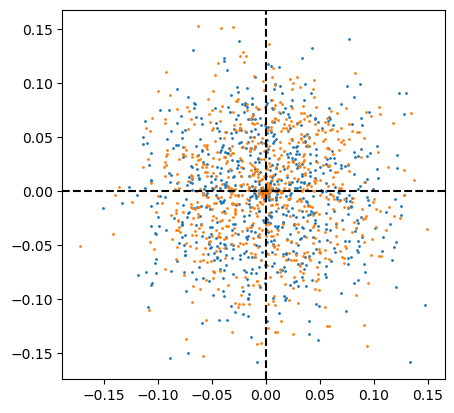

In [127]:
z_0 = 20
z_1 = 0+0j
z_n1 = 0+0j

s_1_3d_test_abs, s_n1_3d_test_abs, s_1_3d_test_ang, s_n1_3d_test_ang = two_ecc_harms_SNR_test({0: np.full(n, np.abs(z_0)), 1: np.abs(s_1), -1: np.abs(s_n1)},
                                                                                              {0: np.full(n, np.angle(z_0)), 1: np.angle(s_1), -1: np.angle(s_n1)})
s_1_3d_test = s_1_3d_test_abs*np.exp(1j*s_1_3d_test_ang)
s_n1_3d_test = s_n1_3d_test_abs*np.exp(1j*s_n1_3d_test_ang)

# plt.scatter(np.real(s_1_3d_test[::100]), np.imag(s_1_3d_test[::100]), s=1, c='C0')
# plt.scatter(np.real(s_n1_3d_test[::100]), np.imag(s_n1_3d_test[::100]), s=1, c='C1')
plt.scatter(np.abs(s_1_3d_test[::100]), np.ang(s_1_3d_test[::100]), s=1, c='C0')
plt.scatter(np.abs(s_n1_3d_test[::100]), np.ang(s_n1_3d_test[::100]), s=1, c='C1')
# plt.axvline(0, c='k', ls='dashed')
# plt.axhline(0, c='k', ls='dashed')
plt.gca().set_aspect('equal')
plt.show()

First plot original method in abs SNR/MA coordinates to compare.

In [118]:
# Generate samples
n = 10**5
s_1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_n1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_1n1_abs, s_1n1_phase = two_ecc_harms_SNR({0: np.full(n, 20), 1: np.abs(s_1), -1: np.abs(s_n1)},
                                           {0: np.full(n, 0), 1: np.angle(s_1), -1: np.angle(s_n1)})
s_1n1 = s_1n1_abs*np.exp(1j*s_1n1_phase)
kde_samples = np.array([np.tile(np.abs(s_1n1), 3), np.hstack([np.angle(s_1n1)-2*np.pi, np.angle(s_1n1), np.angle(s_1n1)+2*np.pi])])
kernel = gaussian_kde(kde_samples)

In [119]:
# Calculate kde and contour levels
kde_abs, kde_ang = np.mgrid[0:np.max(np.abs(s_1n1)):51j, 0:2*np.pi:51j]
kde_z = kernel(np.array([kde_abs.flatten(), kde_ang.flatten()])).reshape(kde_abs.shape)
kde_z /= np.max(kde_z)

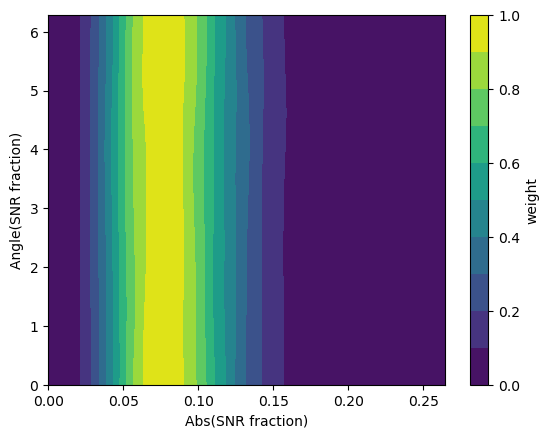

In [120]:
# Make plot
plt.contourf(kde_abs, kde_ang, kde_z, cmap='viridis', vmin=0, vmax=1, levels=np.linspace(0, 1, 11))
plt.colorbar(label='weight')
plt.xlabel('Abs(SNR fraction)')
plt.ylabel('Angle(SNR fraction)')
plt.show()

Now new method. First plotting both distributions individually.

In [128]:
# Generate samples
n = 10**6
s_1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_n1 = np.random.normal(0, 1, n) + 1j*np.random.normal(0, 1, n)
s_1_abs, s_n1_abs, s_1_phase, s_n1_phase = two_ecc_harms_SNR_test({0: np.full(n, np.abs(peak_info['peak_SNRs'][0])), 1: np.abs(s_1), -1: np.abs(s_n1)},
                                                {0: np.full(n, np.angle(peak_info['peak_SNRs'][0])), 1: np.angle(s_1), -1: np.angle(s_n1)})
s_1_3dof = s_1_abs*np.exp(1j*s_1_phase)
s_n1_3dof = s_n1_abs*np.exp(1j*s_n1_phase)
kde_1_samples = np.array([np.tile(np.abs(s_1_3dof), 3), np.hstack([np.angle(s_1_3dof)-2*np.pi, np.angle(s_1_3dof), np.angle(s_1_3dof)+2*np.pi])])
kde_n1_samples = np.array([np.tile(np.abs(s_n1_3dof), 3), np.hstack([np.angle(s_n1_3dof)-2*np.pi, np.angle(s_n1_3dof), np.angle(s_n1_3dof)+2*np.pi])])
kernel_1 = gaussian_kde(kde_1_samples)
kernel_n1 = gaussian_kde(kde_n1_samples)

In [ ]:
# Calculate kde and contour levels
kde_abs_1, kde_ang_1 = np.mgrid[0:np.max(np.abs(s_1)):51j, 0:2*np.pi:51j]
kde_abs_n1, kde_ang_n1 = np.mgrid[0:np.max(np.abs(s_n1)):51j, 0:2*np.pi:51j]
kde_abs_1_3dof, kde_abs_n1_3dof, kde_ang_1_3dof, kde_ang_n1_3dof = two_ecc_harms_SNR_test(
    {0: np.full(len(kde_abs_1.flatten()), np.abs(peak_info['peak_SNRs'][0])), 1: kde_abs_1.flatten(), -1: kde_abs_n1.flatten()},
    {0: np.full(len(kde_abs_n1.flatten()), np.angle(peak_info['peak_SNRs'][0])), 1: kde_ang_1.flatten(), -1: kde_ang_n1.flatten()}
)
kde_z_1 = kernel_1(np.array([kde_abs_1_3dof, kde_ang_1_3dof])).reshape(kde_abs_1.shape)
kde_z_1 /= np.max(kde_z_1)
kde_z_n1 = kernel_n1(np.array([kde_abs_n1_3dof, kde_ang_n1_3dof])).reshape(kde_abs_n1.shape)
kde_z_n1 /= np.max(kde_z_n1)

In [ ]:
# Make plot
plt.contourf(kde_abs_1/20, kde_ang_1, kde_z_1, cmap='viridis', vmin=0, vmax=1, levels=np.linspace(0, 1, 11))
plt.colorbar(label='weight')
plt.xlabel('Abs(SNR fraction)')
plt.ylabel('Angle(SNR fraction)')
plt.title('z_1')
plt.show()

plt.contourf(kde_abs_n1/20, kde_ang_n1, kde_z_n1, cmap='viridis', vmin=0, vmax=1, levels=np.linspace(0, 1, 11))
plt.colorbar(label='weight')
plt.xlabel('Abs(SNR fraction)')
plt.ylabel('Angle(SNR fraction)')
plt.title('z_n1')
plt.show()

In [98]:
# Calculate kde and contour levels
kde_abs_1, kde_ang_1 = np.mgrid[0:0:51j, 0:0:51j]
kde_abs_n1, kde_ang_n1 = np.mgrid[0:np.max(np.abs(s_n1)):51j, 0:2*np.pi:51j]
kde_abs_1_3dof, kde_abs_n1_3dof, kde_ang_1_3dof, kde_ang_n1_3dof = two_ecc_harms_SNR_test({0: np.full(n, np.abs(peak_info['peak_SNRs'][0])), 1: kde_abs_1, -1: kde_abs_n1},
                                                                                          {0: np.full(n, np.angle(peak_info['peak_SNRs'][0])), 1: kde_ang_1, -1: kde_ang_n1})
kde_z_1 = kernel_1(np.array([kde_abs_1_3dof.flatten(), kde_ang_1_3dof.flatten()])).reshape(kde_abs_1.shape)
kde_z_1 /= np.max(kde_z_1)